# Ejercicios de selección de candidatos

## 1. Regresión 
Para el dataset de pingüinos (data/penguins/penguins.csv)
- Selecciona los 3 mejores modelos candidatos para este problema de regresión basándote en su rendimiento (usando la métrica de error cuadrático medio, MSE).
- Usa:
    - `columns = ["Flipper Length (mm)", "Culmen Length (mm)", "Culmen Depth (mm)"]`
    - `target_name = "Body Mass (g)"`

In [ ]:
# Formato de los prints
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

def headr(text):
    return ('\n'+color.UNDERLINE + text + color.END+'\n')

In [ ]:
# Carga de datos
import pandas as pd

penguins = pd.read_csv("../data/penguins/penguins.csv")

# print(penguins.columns)

data_columns = ["Flipper Length (mm)", "Culmen Length (mm)", "Culmen Depth (mm)"]
target_column = "Body Mass (g)"

data_columns.append(target_column)

df = penguins[data_columns]

print(headr("VAR target_column"), "{0:.2f}".format(df[target_column].var()))

## 1. Explorar

In [29]:
df.describe()

,Flipper Length (mm),Culmen Length (mm),Culmen Depth (mm),Body Mass (g)
count,342.000000,342.000000,342.000000,342.000000
mean,200.915205,43.921930,17.151170,4201.754386
std,14.061714,5.459584,1.974793,801.954536
min,172.000000,32.100000,13.100000,2700.000000
25%,190.000000,39.225000,15.600000,3550.000000
50%,197.000000,44.450000,17.300000,4050.000000
75%,213.000000,48.500000,18.700000,4750.000000
max,231.000000,59.600000,21.500000,6300.000000


In [ ]:
df.info()

In [ ]:
# !pip install ydata_profiling

In [ ]:
from ydata_profiling import ProfileReport
profile = ProfileReport(df, title="PenguinsProfiling Report")

In [ ]:
profile.to_notebook_iframe()

## 2. Limpiar

In [20]:
# Valores faltantes

print(headr("Valores faltantes - original: "), df.isna().sum())
df_cleaned = df.dropna()
print(headr("Valores faltantes - limpio:"), df_cleaned.isna().sum())
print(headr("X shape:"), df_cleaned.shape)


Valores faltantes - original: 
 Flipper Length (mm)    2
Culmen Length (mm)     2
Culmen Depth (mm)      2
Body Mass (g)          2
dtype: int64

Valores faltantes - limpio:
 Flipper Length (mm)    0
Culmen Length (mm)     0
Culmen Depth (mm)      0
Body Mass (g)          0
dtype: int64

X shape:
 (342, 4)


In [22]:
# Outliers

# No normal
IQR = df_cleaned.quantile(0.75) - df_cleaned.quantile(0.25)
lower_bound = df_cleaned.quantile(0.25) - (IQR * 3)
upper_bound = df_cleaned.quantile(0.75) + (IQR * 3)

outliers = df[(df_cleaned < lower_bound) | (df_cleaned > upper_bound)]

print(headr("Outliers:"))
outliers.sum()



Outliers:



Flipper Length (mm)    0.0
Culmen Length (mm)     0.0
Culmen Depth (mm)      0.0
Body Mass (g)          0.0
dtype: float64

## 3. Candidatos

1. `LinearRegression`
2. `Ridge`
3. `Lasso`

In [23]:
# Separar características y target
X = df_cleaned.drop(columns=target_column)  # Características
y = df_cleaned[target_column] # Target

In [25]:
# Dividir en entrenamiento y prueba
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit

### Piplines

In [30]:
pipelines = {
    "LinearRegression": Pipeline([('preprocessor', StandardScaler()),('regressor', LinearRegression())]),
    "Lasso": Pipeline([('preprocessor', StandardScaler()),('regressor', Lasso())]),
    "Ridge": Pipeline([('preprocessor', StandardScaler()),('regressor', Ridge())])
}

### CV

In [40]:
def cv_train(name, pipeline, cv):
    print(headr(f"Entrenar {name}"))
    cv_results = cross_validate(pipeline, X_train, y_train, cv=cv, scoring="neg_mean_squared_error", return_estimator=True, return_train_score=True)
    trained_model = cv_results["estimator"][0]
    scores = pd.DataFrame(cv_results)
    scores[["train error", "test error"]] = -scores[["train_score", "test_score"]]

    print("test score (mean-std): {0:.2f} - {1:.2f}".format(scores["test error"].mean(), scores["test error"].std()))
    print("train score (mean-std): {0:.2f} - {1:.2f}".format(scores["train error"].mean(), scores["train error"].std()))
    print("params:", pipeline.named_steps.get("regressor").get_params())

    y_pred = trained_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return {"MAE": round(mae, 2), "MSE": round(scores["test error"].mean(), 2), "R2": round(r2, 2),}

In [41]:
cvss = ShuffleSplit(n_splits=40, test_size=0.2, random_state=0)

print(headr("VAR target_column"), "{0:.2f}".format(df[target_column].var()))

results = {}

for name, pipeline in pipelines.items():
    results[name] = cv_train(name, pipeline, cvss)

print(headr("Resultados:"))
results_df=pd.DataFrame(results)
results_df


VAR target_column
 643131.08

Entrenar LinearRegression

test score (mean-std): 162727.13 - 31125.90
train score (mean-std): 161046.61 - 7752.51
params: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}

Entrenar Lasso

test score (mean-std): 162720.62 - 31074.66
train score (mean-std): 161051.99 - 7752.31
params: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}

Entrenar Ridge

test score (mean-std): 162746.60 - 31028.17
train score (mean-std): 161073.56 - 7752.21
params: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001}

Resultados:



,LinearRegression,Lasso,Ridge
MAE,279.82,280.09,279.91
MSE,162727.13,162720.62,162746.60
R2,0.79,0.79,0.79


### Curva de aprenizaje

##

In [43]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, validation_curve

%matplotlib inline

In [59]:
# Curvas de aprendizaje

train_sizes = np.linspace(0.1, 1.0, num=5, endpoint=True)

def generate_learning_curves(name, pipeline, X, y, train_sizes):
    results = learning_curve(pipeline, X, y, train_sizes=train_sizes,
                             cv=cvss, scoring='neg_mean_squared_error')
    
    train_size, train_scores, test_scores = results[:3]
    train_errors, test_errors = -train_scores, -test_scores
    # print(train_size, train_errors, test_errors)

    # graficar la curva.
    plt.errorbar(train_size, train_errors.mean(axis=1),
                 yerr=train_errors.std(axis=1), label="Error de entrenamiento")
    plt.errorbar(train_size, test_errors.mean(axis=1),
                 yerr=test_errors.std(axis=1), label="Error de prueba")
    plt.legend()

    plt.xscale("log")
    plt.xlabel("Número de muestras en el conjunto de entrenamiento")
    plt.ylabel("MSE")
    plt.title("Curva de aprendizaje para {name}".format(name=name))

    plt.show()

    return train_errors, test_errors

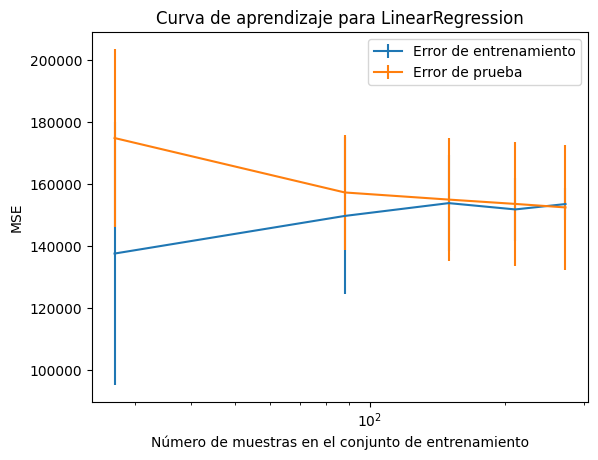

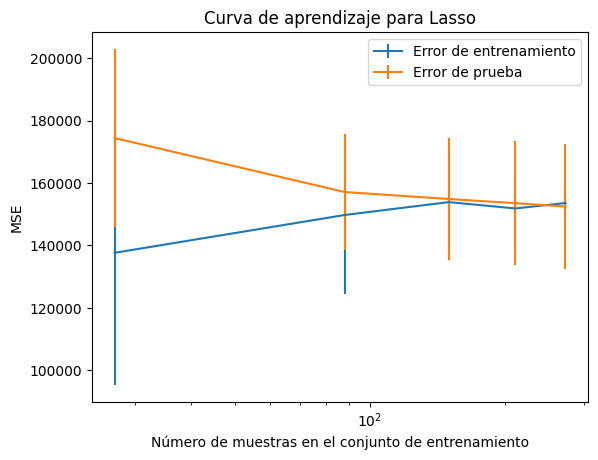

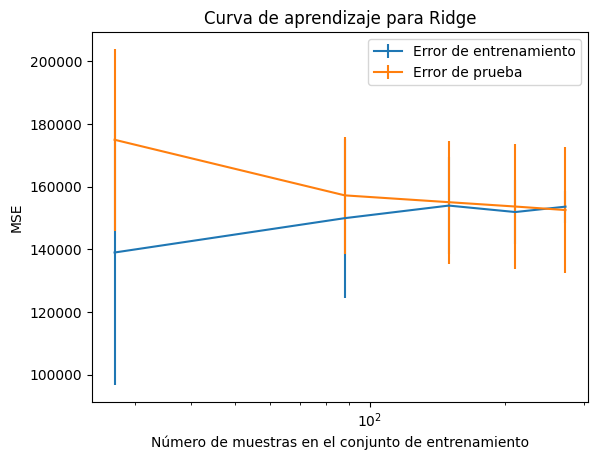

In [60]:
for pipeline_name, pipeline_obj in pipelines.items():
    generate_learning_curves(pipeline_name, pipeline_obj, X, y, train_sizes)

### Curva validación

In [63]:
# Curvas de validación


def generate_validation_curves(name, pipeline, X, y, param_name, param_range):
    train_scores, test_scores = validation_curve(
        pipeline, X, y, param_name=param_name, param_range=param_range,
        cv=cvss, scoring="neg_mean_squared_error")

    train_errors, test_errors = -train_scores, -test_scores

    print(f'MEA medio {test_errors.mean():.2f}', f', std: {test_errors.std():-2f}', )

    # graficar la curva.
    plt.plot(param_range, train_errors.mean(
        axis=1), label="Error de entrenamiento")
    plt.plot(param_range, test_errors.mean(axis=1), label="Error de prueba")
    plt.legend()

    plt.xlabel("Valor del ({param_name})".format(
        param_name=param_name))
    plt.ylabel("MSE")
    plt.title("Curva de validación para {name}".format(name=name))

    plt.show()

    # return train_errors, test_errors

MEA medio 8988738.79 , std: 8839866.851880


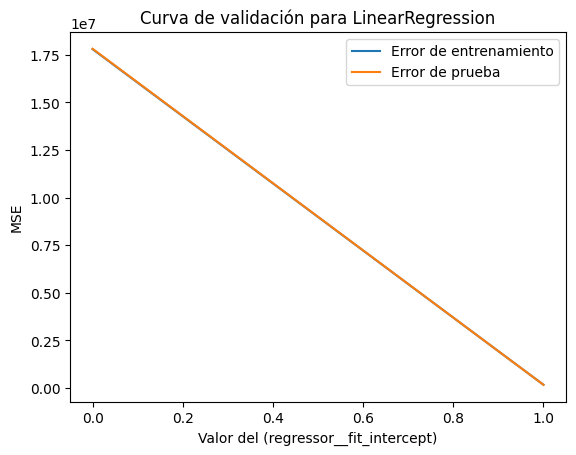

In [64]:
pname= 'LinearRegression'
fit_intercepts = [True, False]
generate_validation_curves(pname, pipelines[pname], X, y, 'regressor__fit_intercept', fit_intercepts)

MEA medio 152438.72 , std: 20022.308892


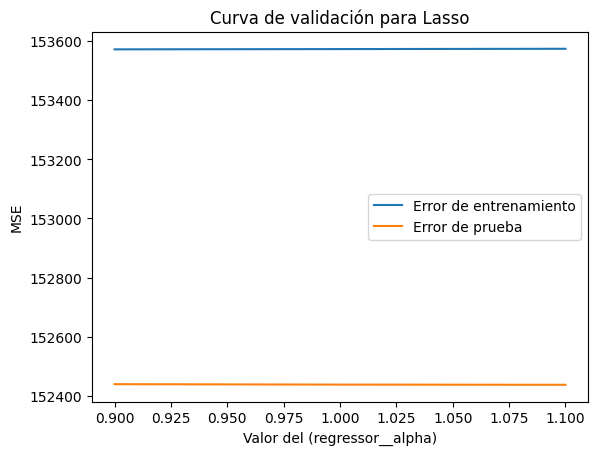

In [68]:
pname= 'Lasso'
alphas = [0.9,1,1.1]
generate_validation_curves(pname, pipelines[pname], X, y, 'regressor__alpha', alphas)

MEA medio 152477.69 , std: 20039.728909


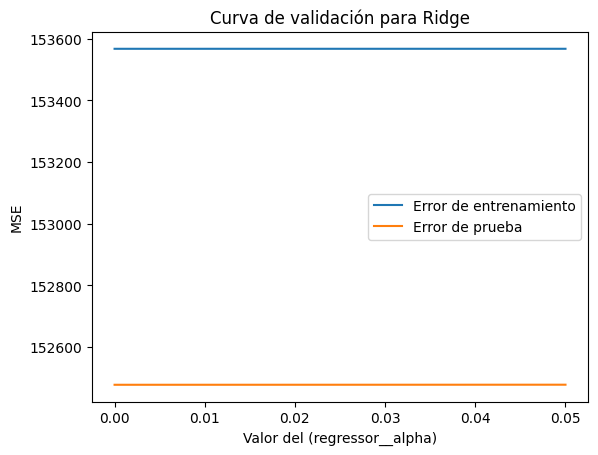

In [72]:
pname= 'Ridge'
alphas = [0,0.01,0.03,0.05]
generate_validation_curves(pname, pipelines[pname], X, y, 'regressor__alpha', alphas)

### Afinar hiperparámentros

In [76]:
from sklearn.model_selection import GridSearchCV

pname= 'Lasso'

param_grid = {
    "regressor__alpha": [0.9,1,1.1],
    "regressor__max_iter": [10, 100, 1000, 10000],
}

grid_search = GridSearchCV(pipelines[pname], param_grid, cv=cvss, scoring="neg_mean_squared_error")

grid_search.fit(X_train, y_train)

print(headr(pname))
print("Mejores hiperparámetros:", grid_search.best_params_)
print(f"Mejor MSE: {-grid_search.best_score_:.2f}")

/anaconda/envs/azureml_py38/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.572e+04, tolerance: 1.485e+04
  model = cd_fast.enet_coordinate_descent(
/anaconda/envs/azureml_py38/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.308e+05, tolerance: 1.392e+04
  model = cd_fast.enet_coordinate_descent(
/anaconda/envs/azureml_py38/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

/anaconda/envs/azureml_py38/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.018e+05, tolerance: 1.392e+04
  model = cd_fast.enet_coordinate_descent(
/anaconda/envs/azureml_py38/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.738e+04, tolerance: 1.464e+04
  model = cd_fast.enet_coordinate_descent(
/anaconda/envs/azureml_py38/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula


Lasso

Mejores hiperparámetros: {'regressor__alpha': 0.9, 'regressor__max_iter': 10}
Mejor MSE: 162719.20


In [79]:
pname= 'Ridge'

param_grid = {
    "regressor__alpha": [0,0.01,0.03,0.05],
    "regressor__solver": ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs']
}

grid_search = GridSearchCV(pipelines[pname], param_grid, cv=cvss, scoring="neg_mean_squared_error")
grid_search.fit(X_train, y_train)

print(headr(pname))
print("Mejores hiperparámetros:", grid_search.best_params_)
print(f"Mejor MSE: {-grid_search.best_score_:.2f}")


Ridge

Mejores hiperparámetros: {'regressor__alpha': 0.01, 'regressor__solver': 'saga'}
Mejor MSE: 162725.89


/anaconda/envs/azureml_py38/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
160 fits failed out of a total of 1280.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
160 fits failed with the following error:
Traceback (most recent call last):
  File "/anaconda/envs/azureml_py38/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/anaconda/envs/azureml_py38/lib/python3.10/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/anaconda/envs/azureml_py38/lib/python3.10/site-packages/sklearn/pipeline.py", line 473, in fit
    self._final_est

### re-entrenar + re-entrenar

In [81]:
pipelines = {
    "LinearRegression": Pipeline([('preprocessor', StandardScaler()),('regressor', LinearRegression())]),
    "Lasso": Pipeline([('preprocessor', StandardScaler()),('regressor', Lasso(alpha=0.9, max_iter=10))]),
    "Ridge": Pipeline([('preprocessor', StandardScaler()),('regressor', Ridge(alpha=0.01, solver='saga'))])
}

In [ ]:
results_final = {}

for name, pipeline in pipelines.items():
    results_final[name] = cv_train(name, pipeline, cvss)


Entrenar LinearRegression

test score (mean-std): 162727.13 - 31125.90
train score (mean-std): 161046.61 - 7752.51
params: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}

Entrenar Lasso



/anaconda/envs/azureml_py38/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.572e+04, tolerance: 1.485e+04
  model = cd_fast.enet_coordinate_descent(
/anaconda/envs/azureml_py38/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.308e+05, tolerance: 1.392e+04
  model = cd_fast.enet_coordinate_descent(
/anaconda/envs/azureml_py38/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

test score (mean-std): 162719.20 - 31078.66
train score (mean-std): 161051.01 - 7752.33
params: {'alpha': 0.9, 'copy_X': True, 'fit_intercept': True, 'max_iter': 10, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}

Entrenar Ridge

test score (mean-std): 162727.24 - 31125.24
train score (mean-std): 161046.62 - 7752.51
params: {'alpha': 0.01, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'saga', 'tol': 0.0001}

Resultados:



,LinearRegression,Lasso,Ridge
MAE,279.82,280.07,279.82
MSE,162727.13,162719.20,162727.24
R2,0.79,0.79,0.79


## 4. Comparar resultados

In [86]:
var_target = df[target_column].var()
print(headr("VAR target_column"), "{0:.2f}".format(var_target))

print(headr("Resultados:"))
results_df = pd.DataFrame(results_final)
results_df.loc['%var']=round(results_df.loc['MSE']/var_target*100,2)
results_df


VAR target_column
 643131.08

Resultados:



,LinearRegression,Lasso,Ridge
MAE,279.82,280.07,279.82
MSE,162727.13,162719.20,162727.24
R2,0.79,0.79,0.79
%var,25.30,25.30,25.30


## 5. Resultado

LinearRegression